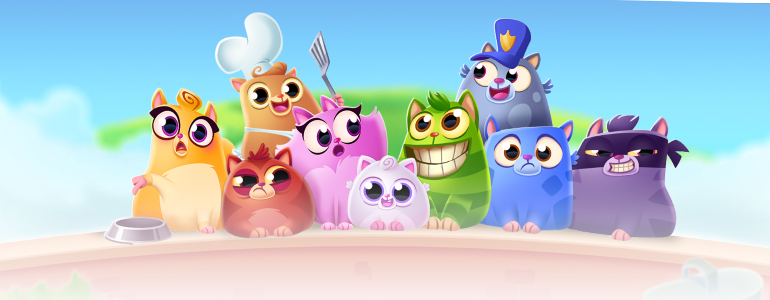

# Cookie Cats A/B Test

Cookie Cats is popular "connect- three" style puzzle game. When users progress through the game, they encounter "Gate" that forces users to wait some time, or to make In-app purchase to progress further. 

Having this in mind - the placement of the "Gate" has huge impact. Initially gate was placet at level 30. Experiment was conducted to see the impact of gate being moved to level 40. 

[Cookie Cats Data Set](https://www.kaggle.com/datasets/mursideyarkin/mobile-games-ab-testing-cookie-cats)

## 0. Dataset overview

In order to define steps for analysis, we need to get familiar with the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import chisquare
import scipy.stats as stats
from statsmodels.stats.power import zt_ind_solve_power
from statsmodels.graphics.gofplots import qqplot
import math
from scipy.stats import norm
from statsmodels.stats.proportion import proportions_ztest

In [2]:
df_original = pd.read_csv("cookie_cats.csv")

In [3]:
print(df_original.head(), end="\n\n")
print(df_original.dtypes, end="\n\n")
print(
    "Dataset has:",
    len(df_original),
    "records,",
    df_original["userid"].nunique(),
    "unique userid values, and",
    df_original.isnull().sum().sum(),
    "nulls.",
)

   userid  version  sum_gamerounds  retention_1  retention_7
0     116  gate_30               3        False        False
1     337  gate_30              38         True        False
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True

userid             int64
version           object
sum_gamerounds     int64
retention_1         bool
retention_7         bool
dtype: object

Dataset has: 90189 records, 90189 unique userid values, and 0 nulls.


The data we have is from 90,189 players that installed the game while the AB-test was running. 

**The variables are:**
- *userid*: A unique number that identifies each player.
- *version*: Whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40). When a player installed the game, they were randomly assigned to one of the groups.
- *sum_gamerounds*: the number of game rounds played by the player during the first 14 days after install.
- *retention_1*: Did the player come back and play 1 day after installing?
- *retention_7*: Did the player come back and play 7 days after installing?

### Limitations

Althoough this dataset is relatively clean there are some topics that has to be addressed:
- There is no information how many gameround on average player has to play to pass one level.
- It is not clear if retention after 1 or 7 days was impacted by move of Gate or by some other factor.
- Time period mismatch: Retention measured after 1 and 7 days, gamerounds calculated during 14 days period.

## 1. Goal

Goal of A/B test is to compare 2 versions of the game (control - gate at level 30, experiment - gate at level 40) and determine which version performs better based on chosen metrics.

## 2. Target Metric

**Primary metric - Engagement**
- Compare average number of game rounds played between 2 groups to assess engagement. 

**Secondary metric - Retention**
- Retention on Day 1 (retention_1): Measure the proportion of players (%) who return on the first day after installation for both groups. This helps assess the immediate impact on retention.
- Retention on Day 7 (retention_7): Measure the proportion of players (%) who return on the seventh day after installation. This captures medium-term retention and whether players are more likely to stay engaged long enough to reach the gate.

## 3. Analysis

Analysis is divided into folowing steps:
1. Data overview 
2. Data clean up
3. Asumptions
4. Definition of hypothesis
5. Tests

### 3.1. Data overview

In [4]:
def summary(dff):
    """
    Function takes dataframe and returs back agregated values.
    Args:
        df: pandas DataFrame
    Returns:
        df_summary: pandas DataFrame
    """
    df_summary = dff.groupby("version").agg(
        {
            "sum_gamerounds": ["count", "count", "mean", "median"],
            "retention_1": "sum",
            "retention_7": "sum",
        }
    )

    df_summary.columns = [
        "userid_count",
        "userid_prp",
        "gamerounds_mean",
        "gamerounds_median",
        "retention_1",
        "retention_7",
    ]

    df_summary["retention_1_prp"] = (
        df_summary["retention_1"] / df_summary["userid_count"] * 100
    )
    df_summary["retention_7_prp"] = (
        df_summary["retention_7"] / df_summary["userid_count"] * 100
    )
    df_summary["userid_prp"] = (
        df_summary["userid_count"] / df_summary["userid_count"].sum() * 100
    )
    return df_summary

In [5]:
df_summary_before = summary(df_original)
df_summary_before.round(3)

,userid_count,userid_prp,gamerounds_mean,gamerounds_median,retention_1,retention_7,retention_1_prp,retention_7_prp
version,,,,,,,,
gate_30,44700,49.563,52.456,17.0,20034,8502,44.819,19.02
gate_40,45489,50.437,51.299,16.0,20119,8279,44.228,18.20


#### Overview summary

- Total sample size is 90189. This suggest sufficient data collected for experiment.
- Sample proportion for control (gate_30) and experiment (gate_40) groups is close to expected proportion - 50%.  However additional test will have to be done to check if there is Sample ratio mismatch.
- **sum_gamerounds** mean is way higher than median and that show possibility for outliers on the higher side. 
- Median **sum_gamerounds** value of 16-17 implies that majority of users even had no chance to get to the gate during 14 days when measurements were taken.
- **retention** proportions seems to be slightly higher for control group (gate_30) compared to experiment group which implies that there may be no possitive effect in retention with change of gate.

### 3.2. Outliers

Data will be checked for outliers.

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64


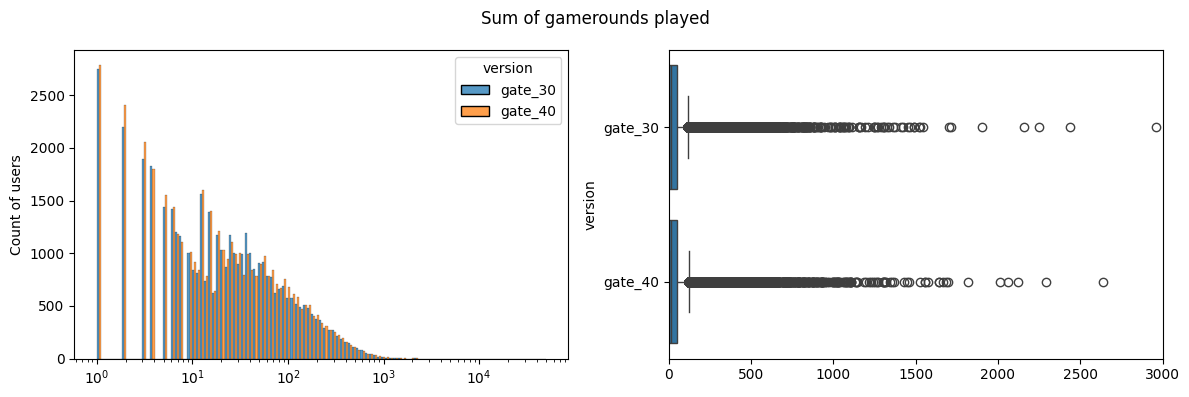

In [6]:
print(df_original["sum_gamerounds"].describe())

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(
    data=df_original,
    x="sum_gamerounds",
    hue="version",
    multiple="dodge",
    log_scale=True,
    ax=axes[0],
)
axes[0].set_xlabel("")
axes[0].set_ylabel("Count of users")

sns.boxplot(data=df_original, x="sum_gamerounds", y="version", ax=axes[1])
axes[1].set_xlim(0, 3000)
axes[1].set_xlabel("")

fig.suptitle("Sum of gamerounds played")

plt.tight_layout()
plt.show()

#### Assumptions

- Maximum **sum_gamerounds** played is 49854. Having in mind that this number is from 14 days, this leads to: 49854 / 14 / 24 = ~148 gamerounds / hour for 24 hours a day, 14 days straight. This is unrealistic, so this value will be removed. Next highest values are ~ 3000 and 3000 / 14 / 24 = ~9 gamerounds / hour, what could potentially be true, so these will be kept in dataset.
- 0 value for **sum_gamerounds** shows that some users downloaded the game, however - never played it.
- To see if movement of the gate had impact it has to be clear the user reached that particular level. As there is no information on how many **gamerounds** on average takes to pass on level, theoretical approach will be used. Absolute minimum **gamerounds** what has to be played to reach levels 30 and 40 is 30 and 40 respectively. Therefor coresponding number will be subracted from **sum_gamerounds** to have the measurement "how many rounds past the gate user potentially played". This measurement is not precise as it is based on assumption, however it lets to reduce dataset to the users who had at least theoretical posibility to be impacted by the **Gate**.

#### Data cleanup

In [7]:
df_original["gamerounds_past_gate"] = df_original.apply(
    lambda row: row["sum_gamerounds"] - int(row["version"][-2:]), axis=1
)

df = df_original.copy()

df.drop(df["sum_gamerounds"].idxmax(), inplace=True)
df = df.loc[df["gamerounds_past_gate"] > 0]

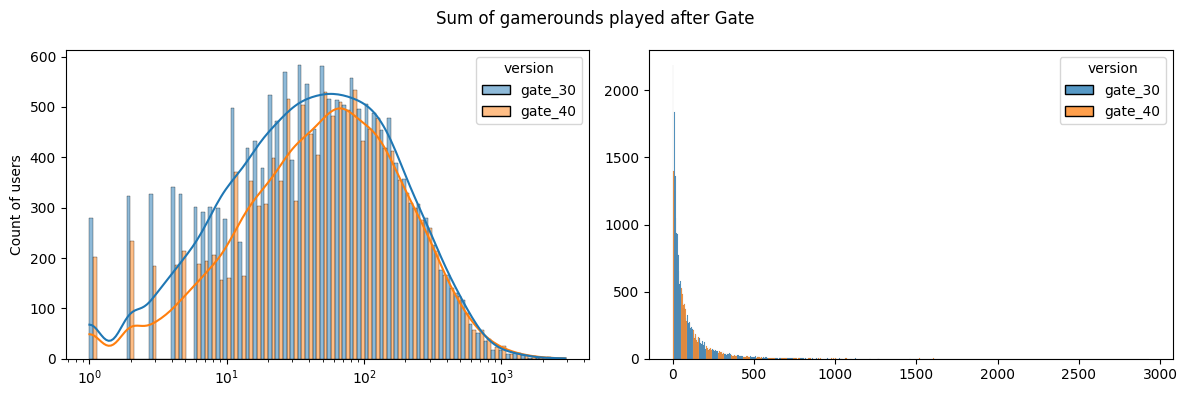

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(
    df,
    x="gamerounds_past_gate",
    kde=True,
    hue="version",
    multiple="dodge",
    log_scale=True,
    ax=axes[0],
)
axes[0].set_xlabel("")
axes[0].set_ylabel("Count of users")

sns.histplot(
    df,
    x="gamerounds_past_gate",
    hue="version",
    multiple="dodge",
    ax=axes[1],
)
axes[1].set_xlabel("")
axes[1].set_ylabel("")

fig.suptitle("Sum of gamerounds played after Gate")

plt.tight_layout()
plt.show()

Calculating summary

In [9]:
df_summary_before[["gamerounds_past_gate_mean", "gamerounds_past_gate_median"]] = (
    df_original.groupby("version").agg({"gamerounds_past_gate": ["mean", "median"]})
)
df_summary_before.transpose()

version,gate_30,gate_40
userid_count,44700.000000,45489.000000
userid_prp,49.562585,50.437415
gamerounds_mean,52.456264,51.298776
gamerounds_median,17.000000,16.000000
retention_1,20034.000000,20119.000000
retention_7,8502.000000,8279.000000
retention_1_prp,44.818792,44.228275
retention_7_prp,19.020134,18.200004
gamerounds_past_gate_mean,22.456264,11.298776
gamerounds_past_gate_median,-13.000000,-24.000000


In [10]:
df_summary_after = summary(df)
df_summary_after[["gamerounds_past_gate_mean", "gamerounds_past_gate_median"]] = (
    df.groupby("version").agg({"gamerounds_past_gate": ["mean", "median"]})
)
df_summary_after.transpose()

version,gate_30,gate_40
userid_count,16357.000000,13600.000000
userid_prp,54.601596,45.398404
gamerounds_mean,123.770435,144.381471
gamerounds_median,73.000000,93.000000
retention_1,13164.000000,11319.000000
retention_7,7265.000000,6676.000000
retention_1_prp,80.479305,83.227941
retention_7_prp,44.415235,49.088235
gamerounds_past_gate_mean,93.770435,104.381471
gamerounds_past_gate_median,43.000000,53.000000


#### Clean up summary

- Sampe size decreased ~60 % for control (Gate_30), and ~70 % for experiment group. This signals issues in *experiment design*.
- Original dataset has sample ration proportion close to 50%: 50.4% for experiment group and 49.6% for control group. After clean up proportion is 45.4% for experiment and 54.6% for control groups. This signals *Sample Ratio Mismatch (SRM)*. 
- Change in mean and median values of **gamerounds** was expected as number of gamerounds below Gate level was removed.
- **Retention** before clean up was higher for control group even if the difference was not so big. After cleaning - **Retention** is better for experiment group.

### 3.3. Assumptions

To conduct Hypothesis test there preconditions which should be fullfilled.
- Independence of observations
- Random sampling. SRM will be checked.
- Normality of data. Here **gamerounds_past_gate** distribution is similar to Log-Normal. For large samples (n > 30) **Central Limit Theorem** allows to assume that the sample **Mean** is approximately normal, even if the underlying data are not.
- Equal variance.

SRM for sample proportion will be checked with Chi-square test. The chi-square test tests the null hypothesis that the categorical data has the given frequencies, in this case: 50-50.

$H_0:$ Assignement to gate_30 and gate_40 data has equal frequencies.

$H_1:$ Assignement to gate_30 and gate_40 data has not equal frequencies.

In [11]:
chi, p = chisquare(df_summary_before["userid_count"])
print(
    "Chi-square results for data before clean up Chi:",
    chi.round(4),
    "p-value:",
    p.round(4),
)

chi, p = chisquare(df_summary_after["userid_count"])
print(
    "Chi-square results for data after clean up Chi:",
    chi.round(4),
    "p-value:",
    p.round(4),
)

Chi-square results for data before clean up Chi: 6.9024 p-value: 0.0086
Chi-square results for data after clean up Chi: 253.732 p-value: 0.0


p-values lower than 0.05 implies that hypothesis about equal split in sample is rejected. 

Normally this would mean that experiment has to be redesigned to ensure equal split between control and experiment groups. As this is not possible in this case, **Bootstrap** method will be used.

#### Sample size

Next step would be calculate minimum sample size which will be used in **Bootstrap** method.
- p1 = 0.5      Baseline conversion rate. In this case expectation is for control and experiment groups to be equal.       
- MDE = 0.02    Minimum Detectable Effect. Minimum change, that needs to be detected.
- alpha = 0.05  Significance level
- power = 0.8   Desired power
- $Z_{\alpha/2}$: Z-score for the significance level (e.g., $\alpha = 0.05$ gives $Z_{\alpha/2} = 1.96$)
- $Z_{\beta}$: Z-score for the statistical power (e.g., 80\% power gives $Z_{\beta} = 0.84$)



$effect\_size = \frac{\text{MDE}}{\sqrt{p_1 \cdot (1 - p_1)}}$

$sample\_size = \frac{(Z_{\alpha/2} + Z_{\beta})^2}{\text{effect\_size}^2}$


In [12]:
p1 = 0.5
MDE = 0.02
alpha = 0.05
power = 0.8

effect_size = MDE / ((p1 * (1 - p1)) ** 0.5)

sample_size = math.ceil(
    zt_ind_solve_power(
        effect_size=effect_size, alpha=alpha, power=power, alternative="two-sided"
    )
)
print("Required sample size per group:", (sample_size))

Required sample size per group: 9812


### 3.4. Definition of hypothesis

To estimate effect of Gate movement from **Gate 30** to **Gate 40** following hypothesis will be tested: 

***For primary Target metrics:***
- There is no Significant difference between number of **rounds played after gate** between experiment and control groups.

***For secondary Target metrics:***
- There is no Significant difference in **retention rate after 1 day** between experiment and control groups.
- There is no Significant difference in **retention rate after 7 day** between experiment and control groups.

$H_0: \mu_{experiment} - \mu_{control} = 0 \\$ 
$H_1: \mu_{experiment} - \mu_{control} \neq 0$ 

where:
- $\mu_{control}$ - average number in control group where Gate was after level 30
- $\mu_{experiment}$ - average number in experiment group where Gate was after level 40

### 3.5. Tests

#### Resampling

As sample size proportion in analyzed dataset is not kept, **Bootstrap** method will be used. As minimum sample size per group is 9812, sample size of 10000 will be chosen to calculate sample mean. Number of iterations in different literature is from 50 to 1000. For this test 500 iterations will be done.

In [13]:
control_data = df[df["version"] == "gate_30"]
experiment_data = df[df["version"] == "gate_40"]

boot_sample_size = 10000
resample_size = 500

boot_gamerounds = []
boot_retention_1 = []
boot_retention_7 = []

for i in range(resample_size):
    control_boot_mean_round = control_data.sample(n=boot_sample_size, replace=True)[
        "gamerounds_past_gate"
    ].mean()
    control_boot_mean_1 = control_data.sample(n=boot_sample_size, replace=True)[
        "retention_1"
    ].mean()
    control_boot_mean_7 = control_data.sample(n=boot_sample_size, replace=True)[
        "retention_7"
    ].mean()

    experiment_boot_mean_round = experiment_data.sample(
        n=boot_sample_size, replace=True
    )["gamerounds_past_gate"].mean()
    experiment_boot_mean_1 = experiment_data.sample(n=boot_sample_size, replace=True)[
        "retention_1"
    ].mean()
    experiment_boot_mean_7 = experiment_data.sample(n=boot_sample_size, replace=True)[
        "retention_7"
    ].mean()

    boot_gamerounds.append([control_boot_mean_round, experiment_boot_mean_round])
    boot_retention_1.append([control_boot_mean_1, experiment_boot_mean_1])
    boot_retention_7.append([control_boot_mean_7, experiment_boot_mean_7])


boot_gamerounds = pd.DataFrame(boot_gamerounds, columns=["gate_30", "gate_40"])
boot_retention_1 = pd.DataFrame(boot_retention_1, columns=["gate_30", "gate_40"])
boot_retention_7 = pd.DataFrame(boot_retention_7, columns=["gate_30", "gate_40"])

#### Sample Distributions

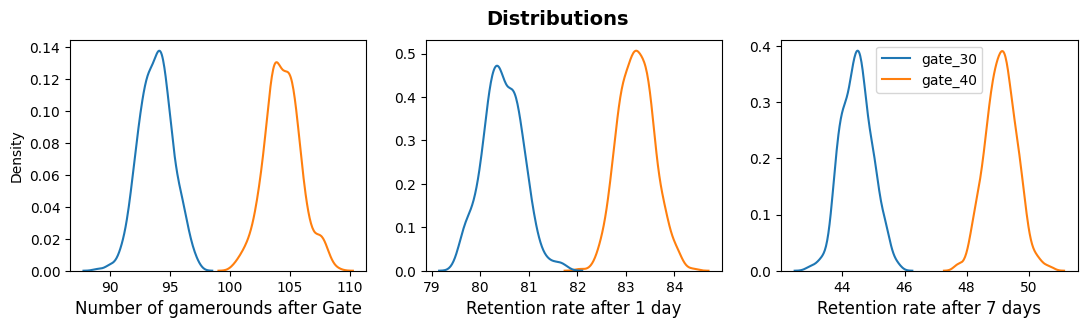

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 3))

sns.kdeplot(data=boot_gamerounds, ax=ax1, legend=False)
ax1.set_xlabel("Number of gamerounds after Gate", size=12)

sns.kdeplot(data=boot_retention_1 * 100, ax=ax2, legend=False)
ax2.set_xlabel("Retention rate after 1 day", size=12)
ax2.set_ylabel("")

sns.kdeplot(data=boot_retention_7 * 100, ax=ax3)
ax3.set_xlabel("Retention rate after 7 days", size=12)
ax3.set_ylabel("")

fig.suptitle("Distributions", fontweight="bold", size=14)
plt.show()

#### Normality check

Difference between experiment (gate_40) and control (gate_30) groups will be calculated. Normality test on this list of differences will be performed using the Shapiro-Wilk test and a Q-Q plot.

$H_0:$ The normality assumption is met.

$H_1:$ The normality assumption is not met.

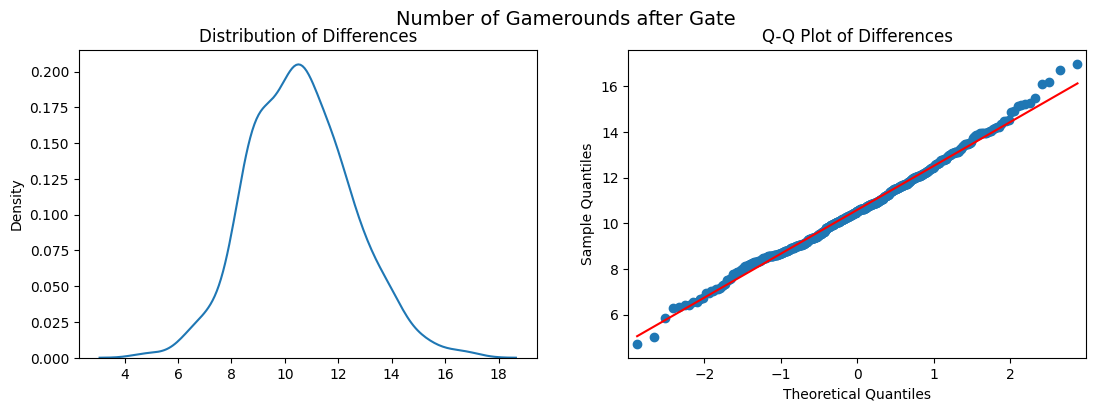

Shapiro-Wilk Test for Gamerounds Differences (Normality check):
W = 0.9944 p-value = 0.0654


In [15]:
boot_gamerounds_diff = boot_gamerounds["gate_40"] - boot_gamerounds["gate_30"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))
sns.kdeplot(data=boot_gamerounds_diff, ax=ax1)
qqplot(boot_gamerounds_diff, line="s", ax=ax2)
ax1.set_title("Distribution of Differences")
ax2.set_title("Q-Q Plot of Differences")
fig.suptitle("Number of Gamerounds after Gate", size=14)
plt.show()

boot_gamerounds_normality = stats.shapiro(boot_gamerounds_diff)
print("Shapiro-Wilk Test for Gamerounds Differences (Normality check):")
print(
    "W =",
    boot_gamerounds_normality.statistic.round(4),
    "p-value =",
    boot_gamerounds_normality.pvalue.round(4),
)

Shapiro-Wilk test's p-value is > 0.05 and hypothesis that **Differences are Normally distributed** failed to be rejected. 

#### Hypothesis testing for Primary metrics

Gamerounds differences are normally distributed, so paired t-test will be used for hypothesis testing.

In [16]:
rounds_t_stat, rounds_p_value = stats.ttest_ind(
    boot_gamerounds["gate_40"], boot_gamerounds["gate_30"], alternative="two-sided"
)

rounds_mean_diff = np.mean(boot_gamerounds_diff).round(4)
rounds_ci_low = np.percentile(boot_gamerounds_diff, 2.5).round(4)
rounds_ci_high = np.percentile(boot_gamerounds_diff, 97.5).round(4)

print("Paired T-Test Results for Gamerounds:")
print(
    "t-statistic =",
    rounds_t_stat.round(4),
    "| p-value =",
    rounds_p_value.round(4),
    "| 95% Confidence Interval:",
    rounds_ci_low,
    "-",
    rounds_ci_high,
)
print("Estimated treatment effect (absolute):", rounds_mean_diff)

Paired T-Test Results for Gamerounds:
t-statistic = 116.5687 | p-value = 0.0 | 95% Confidence Interval: 6.9911 - 14.4903
Estimated treatment effect (absolute): 10.5904


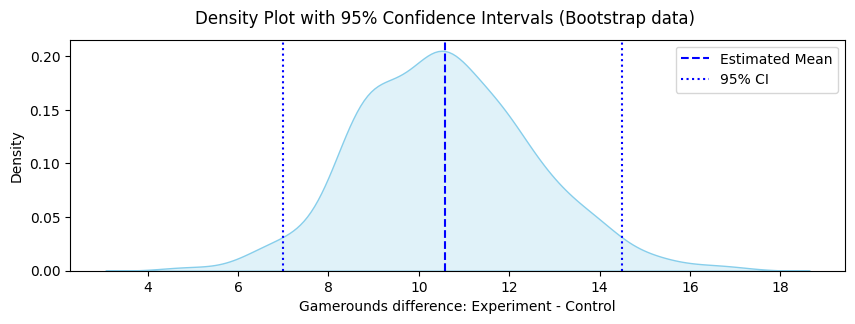

In [17]:
plt.figure(figsize=(10, 3))

sns.kdeplot(boot_gamerounds_diff, fill=True, color="skyblue")
plt.axvline(rounds_mean_diff, color="blue", linestyle="--", label="Estimated Mean")
plt.axvline(rounds_ci_low, color="blue", linestyle=":", label="95% CI")
plt.axvline(rounds_ci_high, color="blue", linestyle=":")

plt.xlabel("Gamerounds difference: Experiment - Control")
plt.ylabel("Density")
plt.suptitle("Density Plot with 95% Confidence Intervals (Bootstrap data)")
plt.legend(loc="upper right")
plt.show()

- With large enough t-statistic and p-value below 0.05 Null Hypothesis is rejected, suggesting that there is significant difference between control and experiment groups.
- Positive estimated treatment effect suggest that experiment (gate_40) group performed better thank control (gate_30) group.
- The confidence interval provides a range in which the true treatment effect lies with a given confidence level of 95%. A confidence interval does not include 0 and this suggests that the treatment effect is likely significant.

#### Hypothesis testing for Secondary metrics

Normality test.

$H_0:$ The normality assumption is met.

$H_1:$ The normality assumption is not met.

In [18]:
boot_retention_1_normality = stats.shapiro(
    (boot_retention_1["gate_40"] - boot_retention_1["gate_30"])
)
print("Shapiro-Wilk Test for Retention after 1 day Differences (Normality check):")
print(
    "W =",
    boot_retention_1_normality.statistic.round(4),
    "p-value =",
    boot_retention_1_normality.pvalue.round(4),
    end="\n\n",
)

boot_retention_7_normality = stats.shapiro(
    (boot_retention_7["gate_40"] - boot_retention_7["gate_30"])
)
print("Shapiro-Wilk Test for Retention after 7 day Differences (Normality check):")
print(
    "W =",
    boot_retention_7_normality.statistic.round(4),
    "p-value =",
    boot_retention_7_normality.pvalue.round(4),
)

Shapiro-Wilk Test for Retention after 1 day Differences (Normality check):
W = 0.9972 p-value = 0.5507

Shapiro-Wilk Test for Retention after 7 day Differences (Normality check):
W = 0.9971 p-value = 0.5111


Shapiro-Wilk test result shows that retention rates are normally distributed, so proportion z-test will be used for hypothesis testing.

In [19]:
def boot_proportion_diff_ci(p1, n1, p2, n2, confidence_level=0.95):
    """
    Calculate the Z-test statistic, p-value, and bootstrap confidence interval for the difference
    in proportions between two groups.

    Parameters:
    p1 : array-like
        Bootstrap sample of proportions for group 1.
    n1 : int
        Sample size for group 1.
    p2 : array-like
        Bootstrap sample of proportions for group 2.
    n2 : int
        Sample size for group 2.
    confidence_level : float, optional
        Confidence level for the bootstrap confidence interval. Default is 0.95, corresponding
        to a 95% confidence interval.

    Returns:
    --------
    z_stat : float
        Z-test statistic for the difference in proportions between the two groups.

    p_value : float
        P-value associated with the Z-test statistic, testing the null hypothesis that the
        proportions are equal between the two groups.

    ci_low : float
        Lower bound of the bootstrap confidence interval for the difference in proportions.

    ci_high : float
        Upper bound of the bootstrap confidence interval for the difference in proportions.

    estimated_diff : float
        Estimated difference in proportions between group 1 and group 2, based on the
        mean of the bootstrap differences.

    Notes:
    ------
    - This function combines a traditional Z-test with bootstrapping for the confidence interval.
    - The Z-test assumes a two-sided test by default.
    - The confidence interval for the difference in proportions is generated from the bootstrap
      sample differences using the specified confidence level.
    """
    count = [p1.mean() * n1, p2.mean() * n2]
    nobs = [n1, n2]

    z_stat, p_value = proportions_ztest(count, nobs, alternative="two-sided")

    bootstrapped_diffs = (p1 - p2) * 100
    estimated_diff = np.mean(bootstrapped_diffs).round(4)

    ci_low = np.percentile(bootstrapped_diffs, 2.5).round(4)
    ci_high = np.percentile(bootstrapped_diffs, 97.5).round(4)

    return z_stat.round(4), p_value.round(4), ci_low, ci_high, estimated_diff

In [20]:
boot_r1_z_stat, boot_r1_p_value, boot_r1_ci_low, boot_r1_ci_high, boot_r1_pr_diff = (
    boot_proportion_diff_ci(
        boot_retention_1["gate_40"],
        resample_size,
        boot_retention_1["gate_30"],
        resample_size,
    )
)

boot_r7_z_stat, boot_r7_p_value, boot_r7_ci_low, boot_r7_ci_high, boot_r7_pr_diff = (
    boot_proportion_diff_ci(
        boot_retention_7["gate_40"],
        resample_size,
        boot_retention_7["gate_30"],
        resample_size,
    )
)

print("Proportion Z-Test Results for Retention after 1 day:")
print(
    "z-statistic =",
    boot_r1_z_stat,
    "| p-value =",
    boot_r1_p_value,
    "| 95% Confidence Interval:",
    boot_r1_ci_low,
    "-",
    boot_r1_ci_high,
)
print("Estimated treatment effect (absolute):", boot_r1_pr_diff, end="\n\n")


print("Proportion Z-Test Results for Retention after 7 days:")
print(
    "z-statistic =",
    boot_r7_z_stat,
    "| p-value =",
    boot_r7_p_value,
    "| 95% Confidence Interval:",
    boot_r7_ci_low,
    "-",
    boot_r7_ci_high,
)
print("Estimated treatment effect (absolute):", boot_r7_pr_diff)

Proportion Z-Test Results for Retention after 1 day:
z-statistic = 1.1299 | p-value = 0.2585 | 95% Confidence Interval: 1.7148 - 3.7153
Estimated treatment effect (absolute): 2.7552

Proportion Z-Test Results for Retention after 7 days:
z-statistic = 1.4755 | p-value = 0.1401 | 95% Confidence Interval: 3.3847 - 5.9252
Estimated treatment effect (absolute): 4.6561


For **Bootstrapped data** Z-test and p-values > 0.05 shows that Null hipothesis is failed to be rejected, and there for there is no significant differences between **Experiment** and **Control** groups for **Retention 1** and **Retention 7**.

For **Retention 1** and **Retention 7** Estimated treatment effect and confidence intervals will be calculated also analitically.

In [21]:
def an_proportion_diff_ci(
    successes_a, size_a, successes_b, size_b, confidence_level=0.95
):
    """
    Calculate the difference in proportions and confidence interval.

    Parameters:
    - successes_a: Number of successes in group A.
    - size_a: Total sample size of group A.
    - successes_b: Number of successes in group B.
    - size_b: Total sample size of group B.
    - confidence_level: Confidence level for the interval (default is 0.95).

    Returns:
    - Z-test, p-value, confidence interval bounds, and estimated difference in proportions.
    """

    p1 = successes_a / size_a
    p2 = successes_b / size_b
    diff = p1 - p2

    se = np.sqrt((p1 * (1 - p1)) / size_a + (p2 * (1 - p2)) / size_b)
    z_score = norm.ppf(1 - (1 - confidence_level) / 2)

    ci_low = ((diff - z_score * se) * 100).round(4)
    ci_high = ((diff + z_score * se) * 100).round(4)

    count = [successes_a, successes_b]
    nobs = [size_a, size_b]
    z_stat, p_value = proportions_ztest(count, nobs, alternative="two-sided")

    return z_stat.round(4), p_value.round(4), ci_low, ci_high, (diff * 100).round(4)

In [22]:
an_r1_z_stat, an_r1_p_value, an_r1_ci_low, an_r1_ci_high, an_r1_pr_diff = (
    an_proportion_diff_ci(
        df_summary_after.loc["gate_40", "retention_1"],
        df_summary_after.loc["gate_40", "userid_count"],
        df_summary_after.loc["gate_30", "retention_1"],
        df_summary_after.loc["gate_30", "userid_count"],
    )
)

an_r7_z_stat, an_r7_p_value, an_r7_ci_low, an_r7_ci_high, an_r7_pr_diff = (
    an_proportion_diff_ci(
        df_summary_after.loc["gate_40", "retention_7"],
        df_summary_after.loc["gate_40", "userid_count"],
        df_summary_after.loc["gate_30", "retention_7"],
        df_summary_after.loc["gate_30", "userid_count"],
    )
)

print("Proportion Z-Test Results for Retention after 1 day:")
print(
    "z-statistic =",
    an_r1_z_stat,
    "| p-value =",
    an_r1_p_value,
    "| 95% Confidence Interval:",
    an_r1_ci_low,
    "-",
    an_r1_ci_high,
)
print("Estimated treatment effect (absolute):", an_r1_pr_diff, end="\n\n")


print("Proportion Z-Test Results for Retention after 7 days:")
print(
    "z-statistic =",
    an_r7_z_stat,
    "| p-value =",
    an_r7_p_value,
    "| 95% Confidence Interval:",
    an_r7_ci_low,
    "-",
    an_r7_ci_high,
)
print("Estimated treatment effect (absolute):", an_r7_pr_diff)

Proportion Z-Test Results for Retention after 1 day:
z-statistic = 6.1292 | p-value = 0.0 | 95% Confidence Interval: 1.875 - 3.6223
Estimated treatment effect (absolute): 2.7486

Proportion Z-Test Results for Retention after 7 days:
z-statistic = 8.0731 | p-value = 0.0 | 95% Confidence Interval: 3.5391 - 5.8069
Estimated treatment effect (absolute): 4.673


- With p-value below 0.05 Null Hypothesis is rejected, suggesting that there is significant difference between control and experiment groups.
- Positive estimated treatment effect suggest that experiment (gate_40) group performed better than control (gate_30) group.

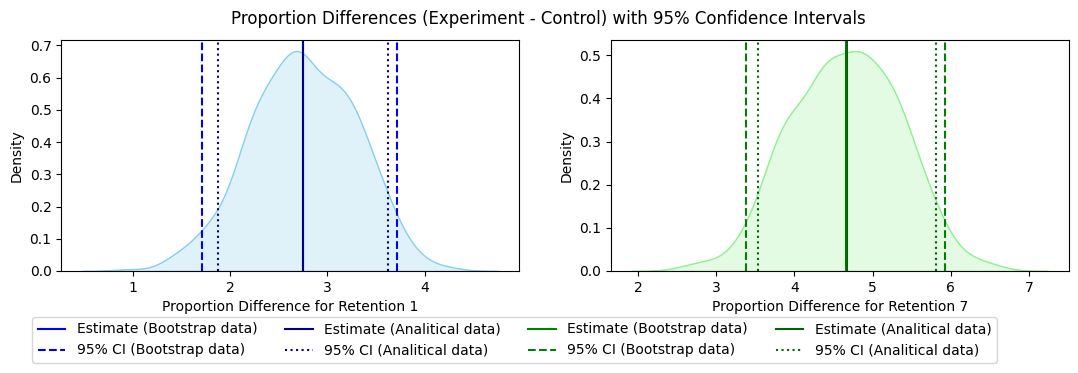

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 3))

sns.kdeplot(
    (boot_retention_1["gate_40"] - boot_retention_1["gate_30"]) * 100,
    fill=True,
    color="skyblue",
    ax=ax1,
)
ax1.axvline(
    boot_r1_pr_diff, color="blue", linestyle="solid", label="Estimate (Bootstrap data)"
)
ax1.axvline(
    boot_r1_ci_low, color="blue", linestyle="--", label="95% CI (Bootstrap data)"
)
ax1.axvline(boot_r1_ci_high, color="blue", linestyle="--")
ax1.axvline(
    an_r1_pr_diff, color="darkblue", linestyle="-", label="Estimate (Analitical data)"
)
ax1.axvline(
    an_r1_ci_low, color="darkblue", linestyle=":", label="95% CI (Analitical data)"
)
ax1.axvline(an_r1_ci_high, color="darkblue", linestyle=":")

sns.kdeplot(
    (boot_retention_7["gate_40"] - boot_retention_7["gate_30"]) * 100,
    fill=True,
    color="lightgreen",
    ax=ax2,
)
ax2.axvline(
    boot_r7_pr_diff, color="green", linestyle="solid", label="Estimate (Bootstrap data)"
)
ax2.axvline(
    boot_r7_ci_low, color="green", linestyle="--", label="95% CI (Bootstrap data)"
)
ax2.axvline(boot_r7_ci_high, color="green", linestyle="--")
ax2.axvline(
    an_r7_pr_diff, color="darkgreen", linestyle="-", label="Estimate (Analitical data)"
)
ax2.axvline(
    an_r7_ci_low, color="darkgreen", linestyle=":", label="95% CI (Analitical data)"
)
ax2.axvline(an_r7_ci_high, color="darkgreen", linestyle=":")

ax1.set_xlabel("Proportion Difference for Retention 1")
ax2.set_xlabel("Proportion Difference for Retention 7")
plt.ylabel("Density")
fig.suptitle(
    "Proportion Differences (Experiment - Control) with 95% Confidence Intervals"
)
fig.legend(bbox_to_anchor=(0.85, -0.02), ncol=4)
plt.show()

- The confidence interval provides a range in which the true treatment effect lies with a given confidence level of 95%. A confidence interval does not include 0 and this suggests that the treatment effect is likely significant.
- Estimated treatment effect values are very similar in both calculation ways (Bootstrap method and analitical method).
- Confidence intervals are wider for Bootstrapped data.

## 4. Summary

1. Desing of experiment should be addressed.
    - Eventhoug assigment to experiment and control groups can be treated as independent, sample ratio proportions were not kept. This becomes even more important after data clean up.
    - Additional information about experiment would be needed, like average number of gamerounds user plays to pass one level to make estimations more precise.
2. Results of analysis
    - Hypothesis tests showed significant differences between experiment and control groups for all target metrics.
    - Average number of **Gamerounds** users played after Gate is ~10 Gamerounds higher for experiment group. This suggests that moving gates makes users play more **Gamerounds**. More **Gamerounds** means that users spend more time playing, and could be potentially exposed to more adds.
    - Retention after 1 day is better by ~2.8%, after 7 days better by ~4.7% for experiment group compare to control group.
    - Gate movement not only makes users play longer, but also more users continue playing this game afer 1 and 7 days.


**Evaluating results from this analysis - it is recomended to implement gate change from level 30 to level 40.**